In [1]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)

In [7]:
import cv2
cv2.__version__

'4.1.0'

In [12]:
import imageio
imageio.plugins.ffmpeg.download() # install imageio-ffmpeg for images

RuntimeError: imageio.ffmpeg.download() has been deprecated. Use 'pip install imageio-ffmpeg' instead.'

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
# from moviepy.editor import VideoFileClip

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [14]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10,11))
    for i, image in enumerate (images):
        plt.subplot(rows, cols, i+1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

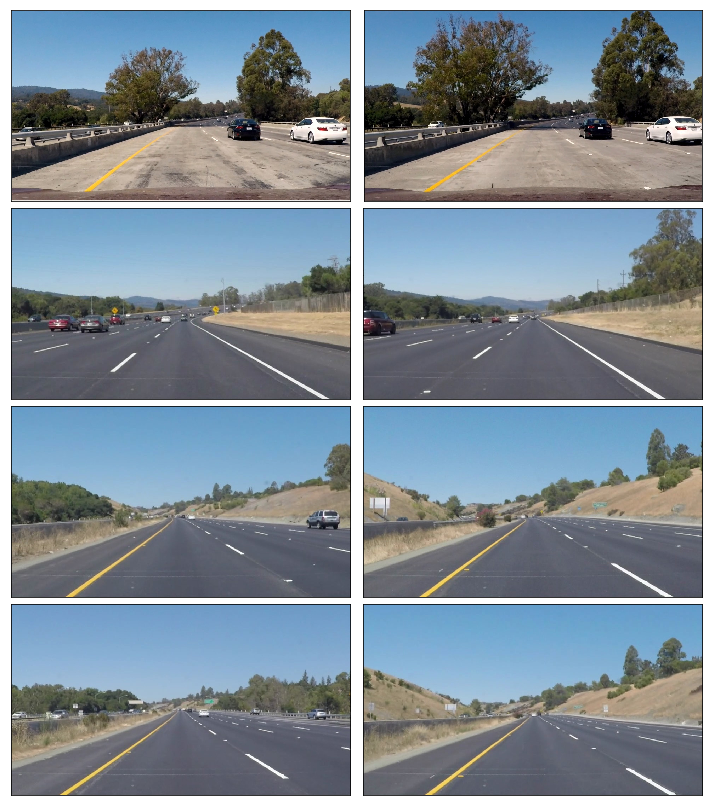

In [15]:
test_images = [plt.imread(path) for path in glob.glob('C:/Users/Sandeep/Desktop/DIATM_Machine_Learning/Road_Lane_Images/*.jpg')]

show_images(test_images)

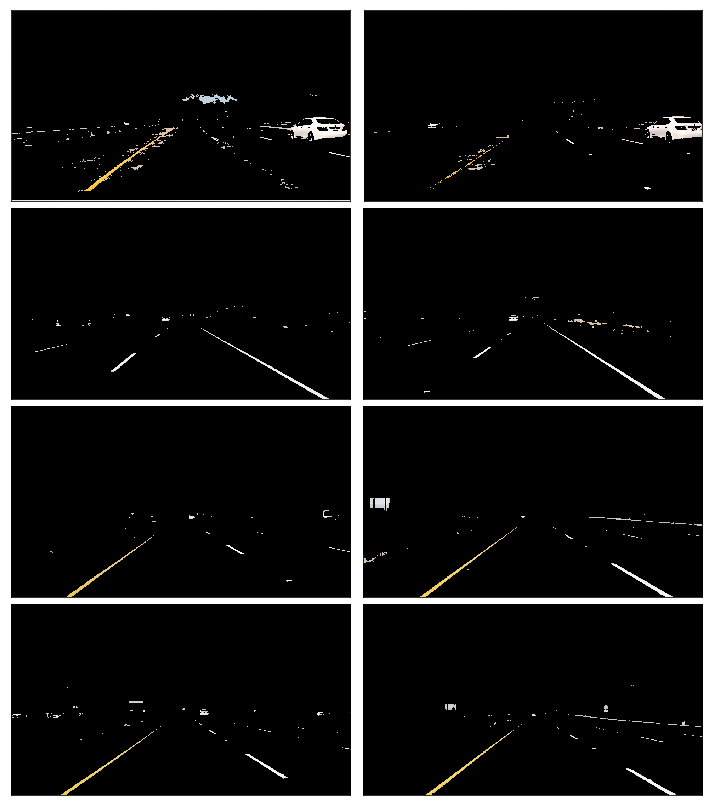

In [16]:
# image is expected be in RGB color space
#only to detect white color and yellow color
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

show_images(list(map(select_rgb_white_yellow, test_images)))

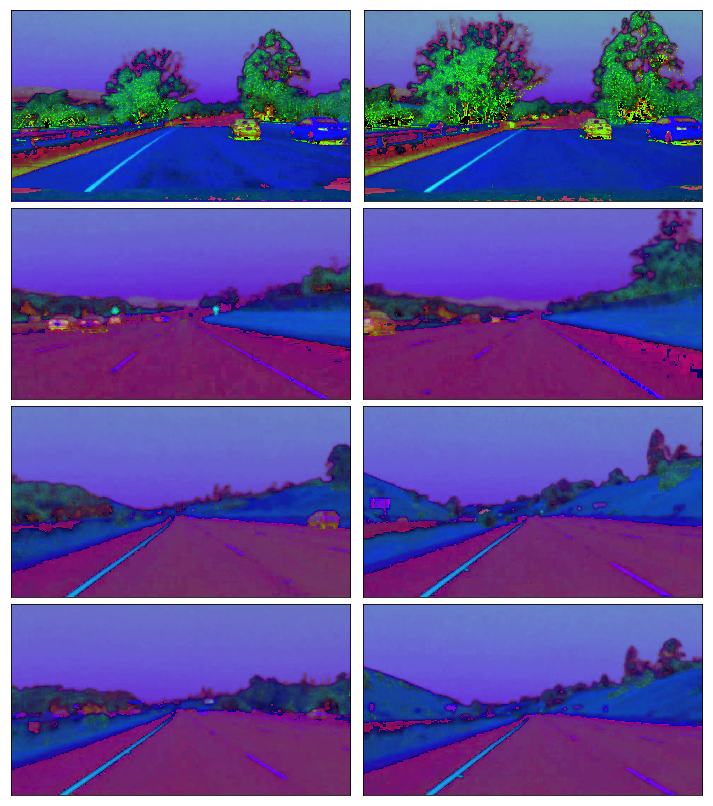

In [17]:
def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

show_images(list(map(convert_hsv, test_images)))

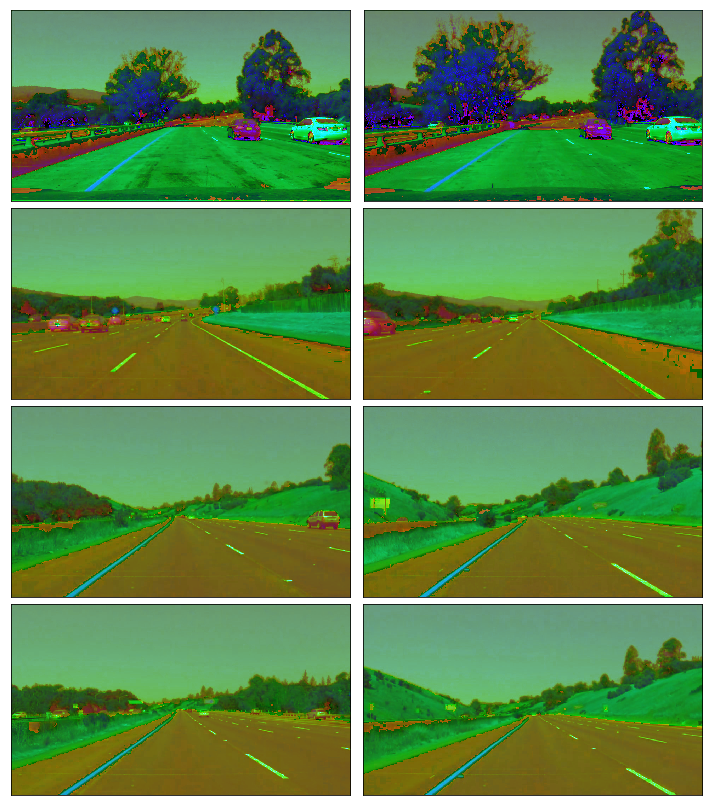

In [18]:
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

show_images(list(map(convert_hls, test_images)))

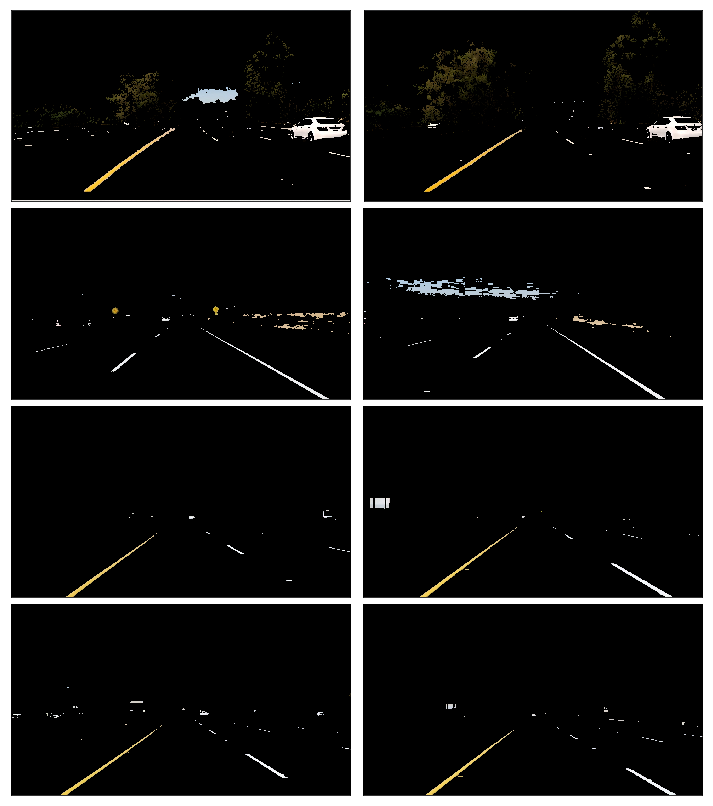

In [19]:
def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

white_yellow_images = list(map(select_white_yellow, test_images))

show_images(white_yellow_images)

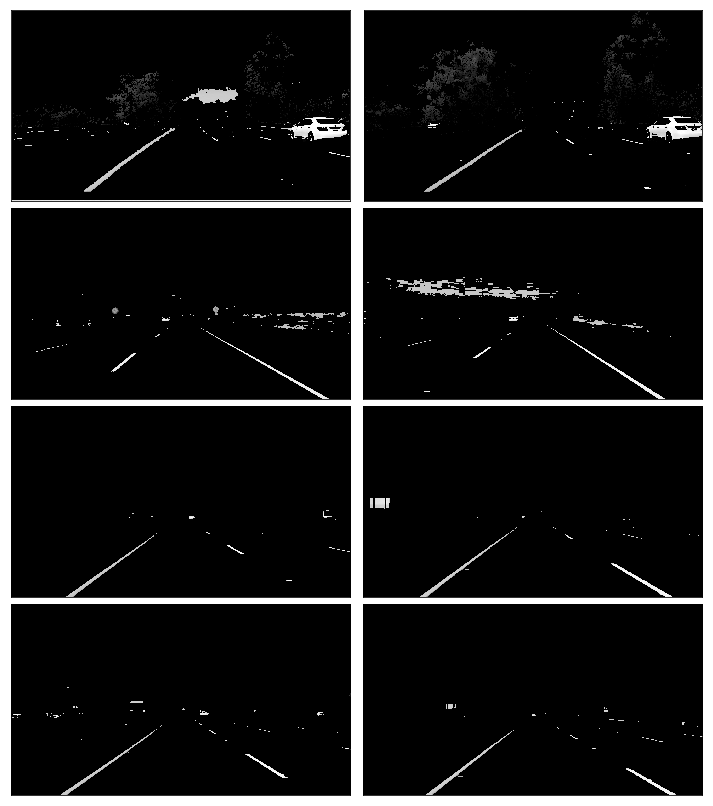

In [20]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))

show_images(gray_images)

In [21]:
def apply_smoothing(image, kernel_size=15):
    """
    kernel_size must be postivie and odd
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

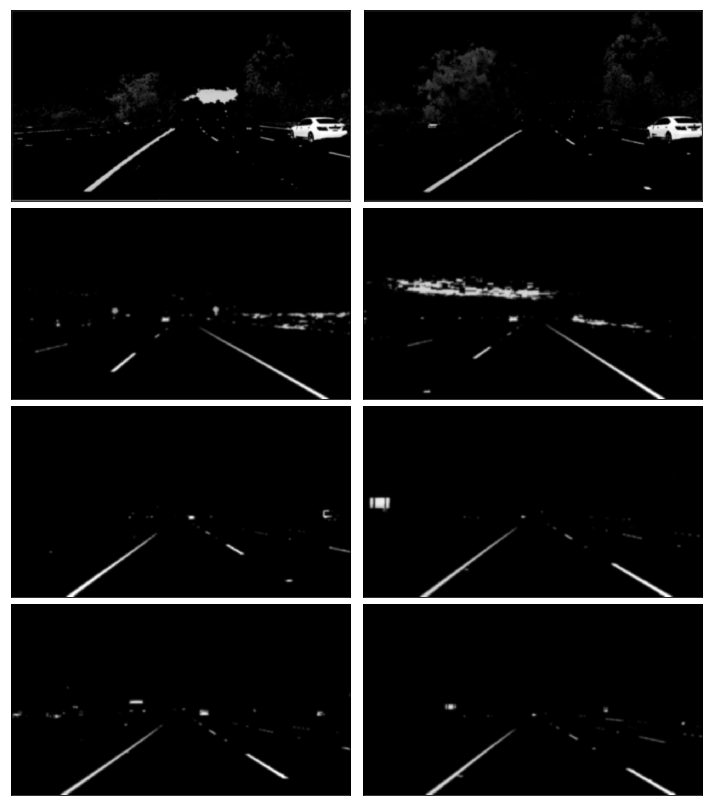

In [22]:
blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))

show_images(blurred_images)

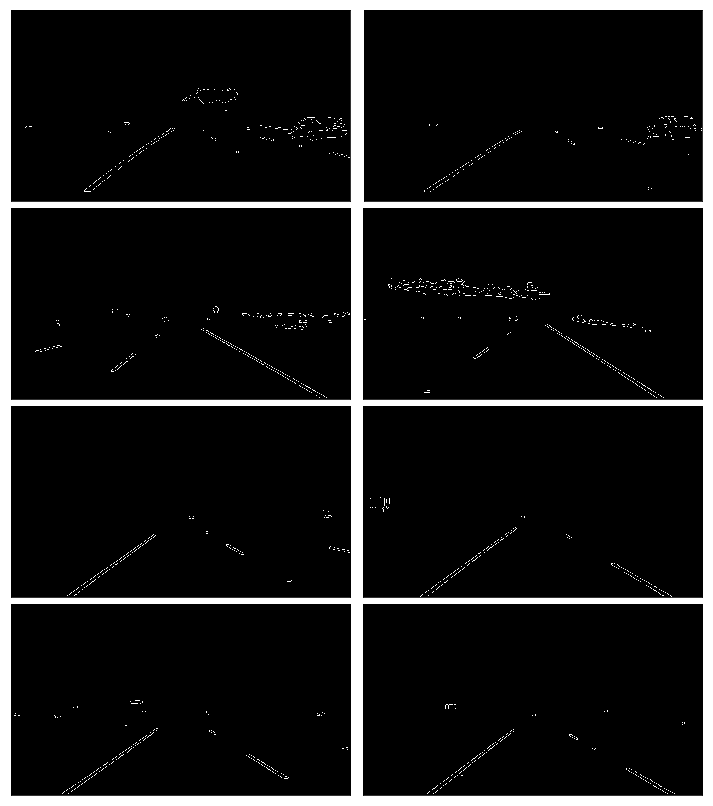

In [23]:
# For detecting the edges
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))

show_images(edge_images)

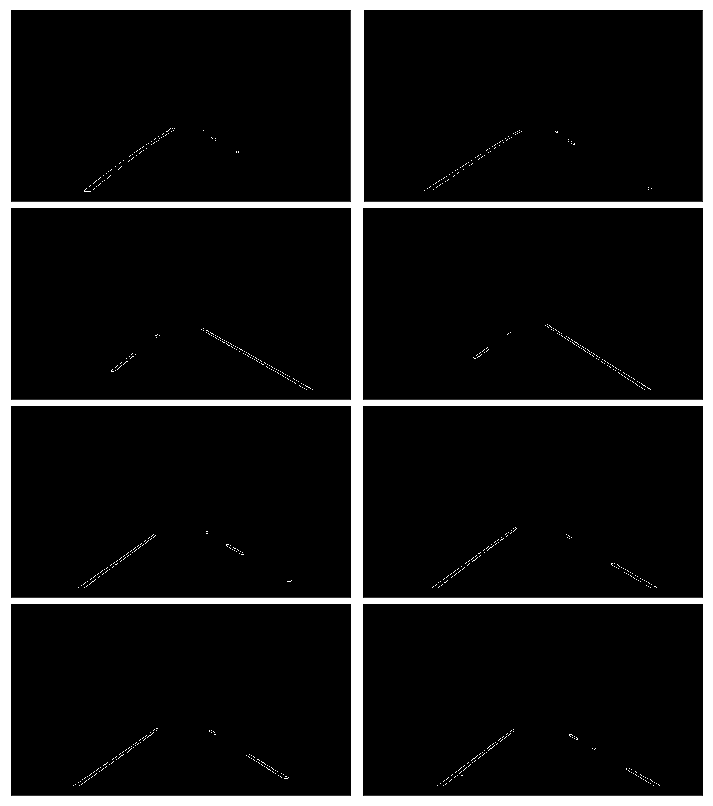

In [24]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)


# images showing the region of interest only
roi_images = list(map(select_region, edge_images))

show_images(roi_images)

In [25]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)


list_of_lines = list(map(hough_lines, roi_images))

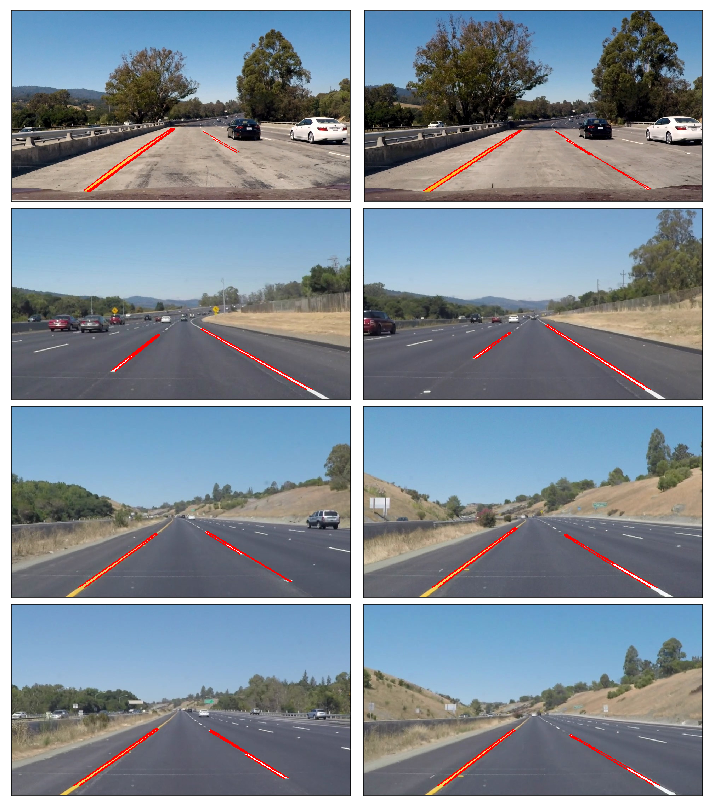

In [26]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)

In [28]:
line_images

[array([[[255, 226, 197],
         [252, 231, 214],
         [237, 233, 230],
         ...,
         [245, 232, 226],
         [245, 231, 228],
         [246, 232, 229]],
 
        [[255, 229, 215],
         [239, 234, 230],
         [223, 237, 248],
         ...,
         [225, 238, 254],
         [225, 239, 250],
         [226, 240, 251]],
 
        [[241, 229, 229],
         [225, 237, 249],
         [129, 164, 194],
         ...,
         [ 67, 111, 148],
         [ 73, 116, 148],
         [116, 159, 191]],
 
        ...,
 
        [[237, 227, 226],
         [236, 226, 225],
         [141, 131, 130],
         ...,
         [ 78,  64,  64],
         [ 78,  64,  63],
         [122, 108, 107]],
 
        [[227, 229, 226],
         [232, 232, 230],
         [232, 232, 230],
         ...,
         [232, 228, 227],
         [232, 231, 227],
         [233, 232, 228]],
 
        [[224, 233, 228],
         [222, 231, 226],
         [225, 234, 229],
         ...,
         [228, 232, 231],
  